In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from models import RNN, get_XY

2023-04-17 16:24:06.024489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **1. Setup**

In [2]:
df = pd.read_csv('./data/final.csv')
df['Month'] = pd.to_datetime(df['Month'], format="%Y%m")
df.set_index('Month', inplace=True)

In [3]:
df.head()

,DP,EP,Mkt-RF,SMB,HML,STR,TB,TS,INF,IP,RV
Month,,,,,,,,,,,
1964-07-01,0.035045,0.061789,1.74,0.50,0.75,1.82,3.46,0.73,1.075269,0.657251,-3.880622
1964-08-01,0.035045,0.061789,-1.44,0.41,0.08,-1.11,3.50,0.71,0.975610,0.652960,-4.338397
1964-09-01,0.035045,0.061789,2.69,-0.34,1.70,1.25,3.53,0.65,1.171875,0.370552,-4.292086
1964-10-01,0.035045,0.061789,0.59,0.87,1.17,1.11,3.57,0.59,1.203252,-1.385040,-4.227420
1964-11-01,0.035045,0.061789,0.00,-0.15,-1.96,-0.68,3.64,0.56,1.397011,3.090023,-3.977059


## **1.1 Input Variables**

In [4]:
# input variables
TEST_SIZE = 0.2
MAX_UNITS = 9
TIME_STEP = 12
MODEL_TYPES = ['simple', 'lstm', 'gru']
FEATURES = df.columns[:-1].to_list()
TARGET = [df.columns[-1]]
NUM_FEATS = len(FEATURES)
# split training and testing data
split = int(df.shape[0] * TEST_SIZE)
train = df.iloc[:(df.shape[0] - split), :].copy()
test = df.iloc[(df.shape[0] - split):, :].copy()

# **2. Data Preparation**

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
# get scaled train arrays for RNN
# x - (batch_size, time_steps, features)
# y - (batch_size, 1)
train[FEATURES] = scaler.fit_transform(train[FEATURES])
train[TARGET] = scaler.fit_transform(train[TARGET])
x_train, y_train = get_XY(
    data=train,
    xlabs=FEATURES,
    ylab=TARGET,
    scaler=scaler,
    time_steps=TIME_STEP
)
# get scaled test arrays for RNN
# x - (batch_size, time_steps, features)
# y - (batch_size, 1)
test[FEATURES] = scaler.fit_transform(test[FEATURES])
test[TARGET] = scaler.fit_transform(test[TARGET])
x_test, y_test = get_XY(
    data=test,
    xlabs=FEATURES,
    ylab=TARGET,
    scaler=scaler,
    time_steps=TIME_STEP
)

In [6]:
print(f'Scaled x_train shape: {x_train.shape}')
print(f'Scaled y_train shape: {y_train.shape}')
print(f'Scaled x_test shape: {x_test.shape}')
print(f'Scaled y_test shape: {y_test.shape}')

Scaled x_train shape: (549, 12, 10)
Scaled y_train shape: (549,)
Scaled x_test shape: (128, 12, 10)
Scaled y_test shape: (128,)


# **3. LSTM Neural Network**

## **3.1 Hidden Units Cross-Validation**

In [7]:
results_lstm = {
    'model': [],
    'hidden units': [],
    'MSE': []
}
for i in range(1, MAX_UNITS + 1):
    lstm = RNN(
        x_train=x_train,
        y_train=y_train,
        units=i,
        type_=MODEL_TYPES[1]
    ).regressor
    mse = lstm.evaluate(x_test, y_test)
    results_lstm['model'].append(MODEL_TYPES[1])
    results_lstm['hidden units'].append(i)
    results_lstm['MSE'].append(mse)

2023-04-17 16:24:09.891162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:09.892864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:09.894053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 2ms/step - loss: 0.0247


2023-04-17 16:24:19.159728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:19.161506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:19.162762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 1s - loss: 0.0174

2023-04-17 16:24:27.979007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:27.980853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:27.982088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0360


2023-04-17 16:24:28.580341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:28.581897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:28.583022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 2ms/step - loss: 0.0286


2023-04-17 16:24:36.912780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:36.914530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:36.915724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0287


2023-04-17 16:24:45.678935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:45.680819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:45.682191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0315


2023-04-17 16:24:54.686175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:24:54.687826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:24:54.688970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0345


2023-04-17 16:25:04.070912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:25:04.072644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:25:04.073812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0234


2023-04-17 16:25:13.024126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:25:13.025580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:25:13.026939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0362


2023-04-17 16:25:21.788960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:25:21.790600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:25:21.791825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 2ms/step - loss: 0.0363


2023-04-17 16:25:30.476286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:25:30.478103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:25:30.479360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [8]:
results_lstm = pd.DataFrame.from_dict(results_lstm)
lstm_units = results_lstm.loc[results_lstm.MSE == results_lstm.MSE.min()]['hidden units'].values[0]

In [9]:
results_lstm

,model,hidden units,MSE
0,lstm,1,0.024658
1,lstm,2,0.035995
2,lstm,3,0.028625
3,lstm,4,0.028694
4,lstm,5,0.031535
5,lstm,6,0.034517
6,lstm,7,0.023444
7,lstm,8,0.036208
8,lstm,9,0.036252


## **3.2 LSTM Training & Prediction**

In [10]:
rnn_lstm = RNN(
    x_train=x_train,
    y_train=y_train,
    units=lstm_units,
    type_=MODEL_TYPES[1]
).regressor
lstm_mse = rnn_lstm.evaluate(x_test, y_test)

2023-04-17 16:25:31.077280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:25:31.079344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:25:31.081282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 2ms/step - loss: 0.0222


2023-04-17 16:25:39.683623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:25:39.685224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:25:39.686587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
print(f'LSTM Neural Network: \n' +
        f'Optimal # of Hidden Units: {lstm_units}\n' +
            f'LSTM MSE: {lstm_mse}')

LSTM Neural Network: 
Optimal # of Hidden Units: 7
LSTM MSE: 0.022183317691087723


## Ignore

In [36]:
# y_pred = rnn_lstm.predict(x_test)
# # inv_yhat = scaler.inverse_transform(y_pred).flatten()
# # inv_y = scaler.inverse_transform(y_test).flatten()
# x_t = x_test.reshape((x_test.shape[0], TIME_STEP * NUM_FEATS))
# # invert RV predictions
# inv_yhat = np.concatenate((y_pred, x_t), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)[:,0]
# # invert RV true
# y_test = y_test.reshape((len(y_test), 1))
# inv_y = np.concatenate((y_test, x_t), axis=1)
# inv_y = scaler.inverse_transform(inv_y)[:,0]

4/4 [==============================] - 0s 2ms/step


In [37]:
# np.sqrt(mean_squared_error(inv_y, inv_yhat))

0.4608209057152051

In [38]:
# results = pd.DataFrame(
#     data={
#     'Prediction': y_pred.flatten(),
#     'Actual': y_test.flatten()
#     },
#     index=test.index.to_list()[-y_pred.shape[0]:]
# )

# **4. Simple RNN**

## **4.1 Hidden Unit Cross-Validation**

In [16]:
results_simple = {
    'model': [],
    'hidden units': [],
    'MSE': []
}
for i in range(1, MAX_UNITS + 1):
    simple = RNN(
        x_train=x_train,
        y_train=y_train,
        units=i,
        type_=MODEL_TYPES[0]
    ).regressor
    mse = simple.evaluate(x_test, y_test)
    results_simple['model'].append(MODEL_TYPES[0])
    results_simple['hidden units'].append(i)
    results_simple['MSE'].append(mse)

4/4 [==============================] - 0s 3ms/step - loss: 0.0301


In [17]:
results_simple = pd.DataFrame.from_dict(results_simple)
simple_units = results_simple.loc[results_simple.MSE == results_simple.MSE.min()]['hidden units'].values[0]

In [18]:
results_simple

,model,hidden units,MSE
0,simple,1,0.029506
1,simple,2,0.031222
2,simple,3,0.024386
3,simple,4,0.034847
4,simple,5,0.034710
5,simple,6,0.026656
6,simple,7,0.039126
7,simple,8,0.036448
8,simple,9,0.030057


## **4.2 Simple RNN Prediction**

In [19]:
rnn_simple = RNN(
    x_train=x_train,
    y_train=y_train,
    units=simple_units,
    type_=MODEL_TYPES[0]
).regressor
simple_mse = rnn_simple.evaluate(x_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0268


In [20]:
print(f'Simple Recurrent Neural Network: \n' +
        f'Optimal # of Hidden Units: {simple_units}\n' +
            f'Simple RNN MSE: {simple_mse}')

Simple Recurrent Neural Network: 
Optimal # of Hidden Units: 3
Simple RNN MSE: 0.026825126260519028


# **5. Gated Recurrent Unit**

## **5.1 Hidden Unit Cross-Validation**

In [21]:
results_gru = {
    'model': [],
    'hidden units': [],
    'MSE': []
}
for i in range(1, MAX_UNITS + 1):
    gru = RNN(
        x_train=x_train,
        y_train=y_train,
        units=i,
        type_=MODEL_TYPES[2]
    ).regressor
    mse = gru.evaluate(x_test, y_test)
    results_gru['model'].append(MODEL_TYPES[2])
    results_gru['hidden units'].append(i)
    results_gru['MSE'].append(mse)

2023-04-17 16:26:30.464230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:26:30.465706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:26:30.466878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0572


2023-04-17 16:26:42.578726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:26:42.580351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:26:42.581711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 1s - loss: 0.0480

2023-04-17 16:26:53.067631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:26:53.069233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:26:53.070708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0444


2023-04-17 16:26:53.447777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:26:53.449253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:26:53.450390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 3ms/step - loss: 0.0312


2023-04-17 16:27:06.515024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:27:06.517778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:27:06.519576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 3ms/step - loss: 0.0214


2023-04-17 16:27:21.188706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:27:21.190671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:27:21.192186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0543


2023-04-17 16:27:31.857528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:27:31.860458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:27:31.861970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0246


2023-04-17 16:27:44.251982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:27:44.253795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:27:44.255256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 5ms/step - loss: 0.0372


2023-04-17 16:27:56.975989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:27:56.978224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:27:56.979865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 5ms/step - loss: 0.0365


2023-04-17 16:28:12.220380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:28:12.222585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:28:12.224732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 0.0313


In [22]:
results_gru = pd.DataFrame.from_dict(results_gru)
gru_units = results_gru.loc[results_gru.MSE == results_gru.MSE.min()]['hidden units'].values[0]

## **5.2 GRU Prediction**

In [23]:
rnn_gru = RNN(
    x_train=x_train,
    y_train=y_train,
    units=lstm_units,
    type_=MODEL_TYPES[2]
).regressor
gru_mse = rnn_gru.evaluate(x_test, y_test)

2023-04-17 16:28:25.749777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 16:28:25.751581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 16:28:25.752866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 3ms/step - loss: 0.0327


In [28]:
print(f'GRU Neural Network: \n' +
        f'Optimal # of Hidden Units: {gru_units}\n' +
            f'GRU MSE: {gru_mse}')

GRU Neural Network: 
Optimal # of Hidden Units: 4
GRU MSE: 0.03270714730024338


# **6. Summary**

In [25]:
totals = pd.concat([results_simple, results_lstm, results_gru], axis=0, ignore_index=True)

In [26]:
results_gru

,model,hidden units,MSE
0,gru,1,0.057236
1,gru,2,0.044360
2,gru,3,0.031178
3,gru,4,0.021409
4,gru,5,0.054321
5,gru,6,0.024578
6,gru,7,0.037188
7,gru,8,0.036483
8,gru,9,0.031259


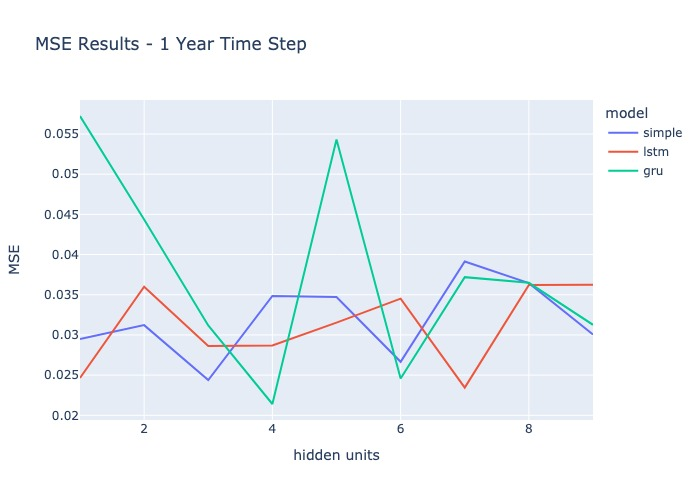

In [34]:
fig = px.line(totals, x='hidden units', y='MSE', color='model', title='MSE Results - 1 Year Time Step')
fig.show(renderer='jpeg')